In [1]:
!pip install colors_utils

ERROR: Could not find a version that satisfies the requirement colors_utils (from versions: none)
ERROR: No matching distribution found for colors_utils


In [2]:
import openpyxl as pxl
import numpy as np
import matplotlib.pyplot as plt
from  colors_utils import *
from tqdm import trange
import pickle
import os



In [3]:
def load_obj(name):
    """
        Generic function to load a bin obj with pickle protocol

    Input :
        - name (str) : path to where the obj is
    Output :
        - (python object) : loaded object
        
    Possible mistakes :
        - Wrong path 
    """
    
    if os.path.dirname(os.path.normpath(name)) != '':
        os.makedirs(os.path.dirname(os.path.normpath(name)), exist_ok=True)
    else:
        name = os.path.join(os.getcwd(),os.path.normpath(name))
    if name[-4:]!='.pkl':
        name += '.pkl'
    with open(os.path.normpath(name), 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name ):
    """
        Generic function to save an obj with pickle protocol

    Input :
        - obj (python var) : object to be saved in binary format
        - name (str) : path to where the obj shoud be saved

    Possible mistakes :
        - Permissions denied, restart notebook from an admin shell
        - Folders aren't callable, change your folders
    """
    
    if os.path.dirname(os.path.normpath(name)) != '':
        os.makedirs(os.path.dirname(os.path.normpath(name)), exist_ok=True)
    else:
        name = os.path.join(os.getcwd(),os.path.normpath(name))
    
    if name[-4:]!='.pkl':
        name += '.pkl'
    with open( os.path.normpath(name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def charge_calibration(path, calibration_date=r'20250225', 
                       all_LEDs = ['Violet', 'Blue', 'Green', 'Yellow', 'Red'],
                      verbose = True):

    
    
    print('\nC O R R E C T I O N \n')
    
    correction = {'Red':None,
                  'Yellow':None,
                  'Green':None,
                  'Blue':None,
                  'Violet':None, 
                 }
    for i in range(len(all_LEDs)):
        temp_color_name = all_LEDs[i]
        temp_corr = input('Enter the measured power of the {} LED at 5V (mW): '.format(temp_color_name) )
        try :
            temp_corr = float(temp_corr)
            print('The {} LED power function will be corrected.'.format(temp_color_name) )
            correction[temp_color_name]=temp_corr
        except :
            print('No correction will be applied to the {} LED.'.format(temp_color_name))
            pass

    print('\nF I L T E R S \n')
    
    filters = {'Red':1,
                'Yellow':1,
                'Green':1,
                'Blue':1,
                'Violet':1, 
                 }

    for i in range(len(all_LEDs)):
        temp_color_name = all_LEDs[i]
        temp_filter = input('Enter the filter transmittance value applied to the {} LED: '.format(temp_color_name))
        try :
            temp_filter = float(temp_filter)
            print('The {} LED will be filtered.'.format(temp_color_name))
            filters[temp_color_name]=temp_filter
        except :
            print('No filter will be applied to the {} LED.'.format(temp_color_name))
            pass
    
    all_LEDs = np.flip(all_LEDs)
    wb = pxl.load_workbook(path)
    ws = wb[calibration_date]
    #col_number = 5
    #colors = ['625 nm','530 nm','490 nm', '415 nm', '385 nm']
    
    fiber_to_mea_red = {'Red':1,
                        'Yellow':1,
                        'Green':1,
                        'Blue':1,
                        'Violet':1, 
                 }
    np.ones(len(all_LEDs))
    
    calibrations = {'voltages' : np.array([ws.cell(row=i, column=1).value for i in range(4,21)])}
    for col_i in range(0,len(all_LEDs)):
        color_name = all_LEDs[col_i]
        temp_ratio = ws.cell(row=23, column=2+col_i).value/ws.cell(row=20, column=2+col_i).value
        fiber_to_mea_red[color_name]=temp_ratio 
        
        calibrations[color_name]=np.array([ws.cell(row=i, column=2+col_i).value for i in range(4,21)])

        
        if correction[color_name]!=None :
            calibrations[color_name]=calibrations[color_name]*correction[color_name]/calibrations[color_name][-1]
    
        calibrations[color_name]=calibrations[color_name]*filters[color_name]*fiber_to_mea_red[color_name]
        print(calibrations[color_name])
    min_pow=0
    ind=1
    old_pow=calibrations[all_LEDs[0]][ind]
    while min_pow==0 :
        for col_name in all_LEDs :
            temp_pow=calibrations[col_name][ind]
            min_pow = min(temp_pow,old_pow)
            old_pow=temp_pow
        ind+=1
    if ind>=1 :
        calibrations['voltages']=np.concatenate(([0],calibrations['voltages'][ind:]))
        for col_name in all_LEDs :
            calibrations[col_name]=np.concatenate(([0],calibrations[col_name][ind:]))


    if verbose :
        for col_name in all_LEDs :
        
            plt.plot((calibrations['voltages']),calibrations[col_name], label=col_name)
            plt.yscale('log')
            plt.xscale('log')
            plt.xlabel('Tension (V)')
            plt.ylabel('Power (µW/cm²)')
            plt.title('{} LED'.format(col_name))
            plt.legend()
            plt.show(block=False)
                 
    return calibrations, fiber_to_mea_red



def get_voltages(Ptot, calibration, all_LEDs = ['Violet', 'Blue', 'Green', 'Yellow', 'Red']):
    voltages = calibration['voltages']
    driving_tension = []
    
    for col_i in range(len(all_LEDs)):
        col_name = all_LEDs[col_i]
        temp_P = float(Ptot[col_i])
        
        # Return 0 voltage if the power is 0
        if temp_P == 0:
            driving_tension.append(0)
            print(f"{col_name}: Power is 0, so voltage is 0 V.")
            continue
        
        calibration_list = calibration[col_name]
        
        if temp_P > calibration_list[-1]:
            raise ValueError('The given power value is too high. Try putting a lower value.')
    
        if temp_P in calibration_list:
            index = np.where(calibration_list == temp_P)
            res_voltage = voltages[index][0]
        else:
            low_ind = 0
            high_ind = len(calibration_list) - 1
            
            for i in range(len(calibration_list)):
                if calibration_list[i] < temp_P and calibration_list[i] > calibration_list[low_ind]:
                    low_ind = i
                if calibration_list[i] > temp_P and calibration_list[i] < calibration_list[high_ind]:
                    high_ind = i
            
            res_voltage = voltages[low_ind] + (voltages[high_ind] - voltages[low_ind]) * (temp_P - calibration_list[low_ind]) / (calibration_list[high_ind] - calibration_list[low_ind])
            driving_tension.append(res_voltage)

            print(f'{col_name}: {res_voltage} V')
            
    driving_tension = np.array(driving_tension)
    return driving_tension



C O R R E C T I O N 

Enter the measured power of the Violet LED at 5V (mW): 
No correction will be applied to the Violet LED.
Enter the measured power of the Blue LED at 5V (mW): 
No correction will be applied to the Blue LED.
Enter the measured power of the Green LED at 5V (mW): 
No correction will be applied to the Green LED.
Enter the measured power of the Yellow LED at 5V (mW): 
No correction will be applied to the Yellow LED.
Enter the measured power of the Red LED at 5V (mW): 
No correction will be applied to the Red LED.

F I L T E R S 

Enter the filter transmittance value applied to the Violet LED: 
No filter will be applied to the Violet LED.
Enter the filter transmittance value applied to the Blue LED: 
No filter will be applied to the Blue LED.
Enter the filter transmittance value applied to the Green LED: 
No filter will be applied to the Green LED.
Enter the filter transmittance value applied to the Yellow LED: 
No filter will be applied to the Yellow LED.
Enter the fil

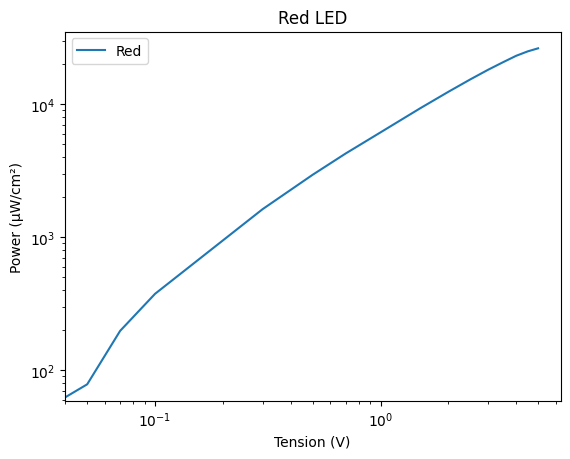

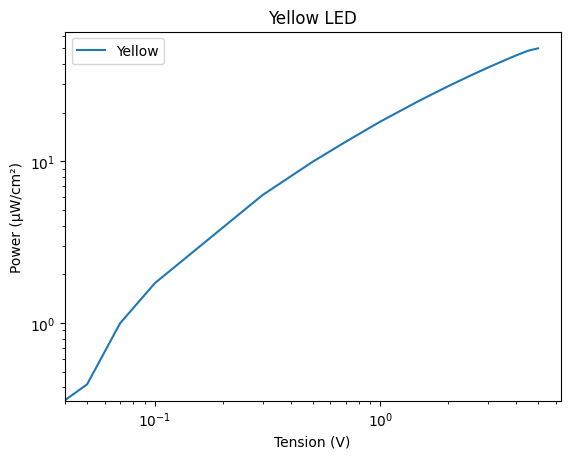

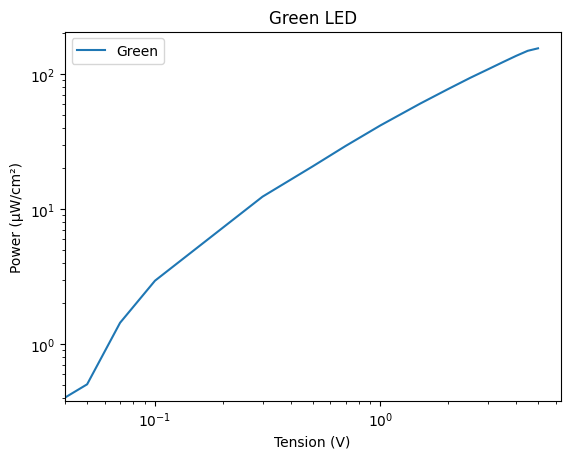

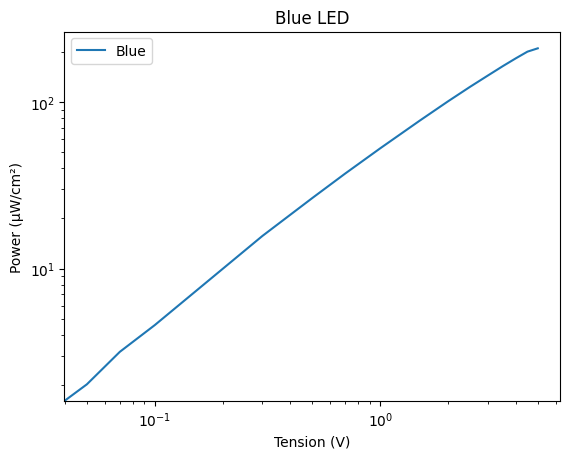

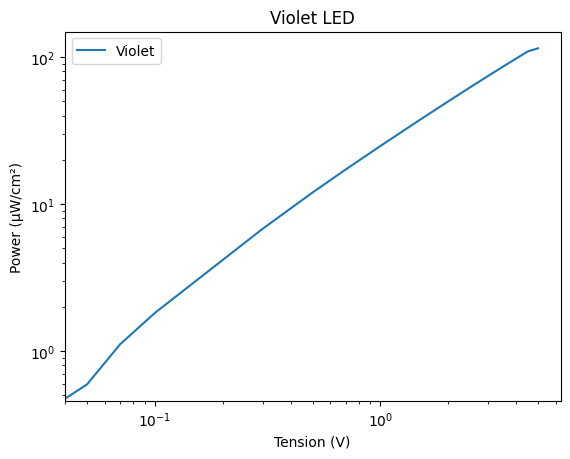

In [4]:
violet_filter = 0.0007448403609977213
yellow_filter = 0.032160625444208

calibration_file = r"./calibration_5_colors_w_MEA_20230403.xlsx"

calibration, _ = charge_calibration(calibration_file, verbose=True)

LED Power Mix:
Violet: 0.38 µW/cm²
Yellow: 2.28 µW/cm²

Ptot with 2 LED Power Values (µW/cm²):
Violet: 0.375
Yellow: 2.284

Isomerisation rate:
Scones: 5.4e+02
Mela: 5.6e+03
Rods: 2.0e+04
Mcones: 1.0e+04
RedOpsin: 1.0e+02


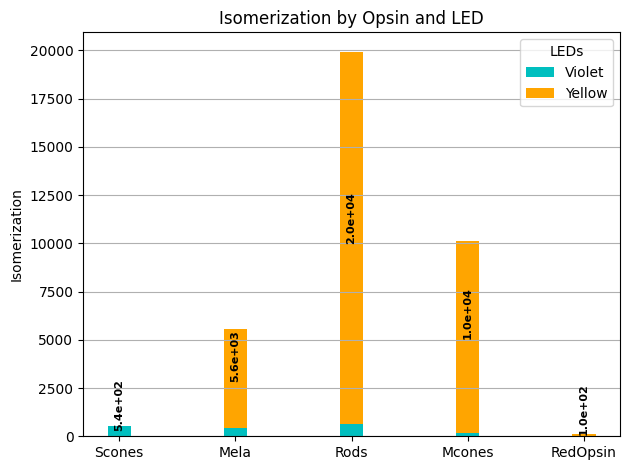

Violet: 0.03150782800296457 V
Yellow: 0.12334303268976456 V


array([0.03150783, 0.12334303])

In [5]:
isomerisation_target = {
    "Scones":5e2,
    "Mcones":1e4,
    'Rods':2e4
}
selected_LEDs = ['Violet', 'Yellow']


Ptot_solution = get_mix_color(isomerisation_target, selected_LEDs = selected_LEDs, ledDATA_path = './IlluminationData.pkl')

plot_isomerisations([Ptot_solution], selected_LEDs = selected_LEDs, colors={'Violet':'c','Yellow':'orange'},ledDATA_path = './IlluminationData.pkl')
plt.show()
plt.close('all')
get_voltages(Ptot_solution, calibration, selected_LEDs)

In [6]:
selected_LEDs = ["Violet", "Blue", "Green", "Yellow", "Red"]

file_path = 'Example_PowerList.txt'  # Change this to your file path
output_file_path = file_path.replace('PowerList', 'VoltageList')  # Replace 'PowerList' with 'VoltageList' in the file name

with open(file_path, 'r') as file, open(output_file_path, 'w') as output_file:
    for line in file:
        Ptot = list(map(int, line.split()))
        
        # Ensure that the number of columns in the line matches the number of selected LEDs
        assert len(Ptot) == len(selected_LEDs), f"Mismatch: {len(Ptot)} columns in file, but {len(selected_LEDs)} LEDs selected."
        
        voltage = get_voltages(Ptot, calibration, selected_LEDs)  # Assuming get_voltages is defined
        print(Ptot)
        # Write the calculated voltages to the output file in the same format
        output_file.write('\t'.join(map(str, voltage)) + '\n')


Violet: Power is 0, so voltage is 0 V.
Blue: Power is 0, so voltage is 0 V.
Green: 0.2501600590987441 V
Yellow: 2.0872413793103446 V
Red: 0.0916902641584951 V
[0, 0, 10, 30, 326]
Violet: Power is 0, so voltage is 0 V.
Blue: Power is 0, so voltage is 0 V.
Green: 0.12250677173110071 V
Yellow: 0.4501974248927038 V
Red: 0.16190853894937524 V
[0, 0, 4, 9, 762]
Violet: Power is 0, so voltage is 0 V.
Blue: Power is 0, so voltage is 0 V.
Green: 0.2501600590987441 V
Yellow: 0.4501974248927038 V
Red: 0.06521210765675092 V
[0, 0, 10, 9, 169]
Violet: Power is 0, so voltage is 0 V.
Blue: Power is 0, so voltage is 0 V.
Green: 0.06066997518610422 V
Yellow: 3.263519313304721 V
Red: 0.017237954713126384 V
[0, 0, 1, 40, 27]
Violet: Power is 0, so voltage is 0 V.
Blue: Power is 0, so voltage is 0 V.
Green: 0.1650578675203152 V
Yellow: 1.7004833836858004 V
Red: 0.17247240767285443 V
[0, 0, 6, 26, 828]
Violet: Power is 0, so voltage is 0 V.
Blue: Power is 0, so voltage is 0 V.
Green: 0.10123122383649348 V
